# ImagenetOS

In [73]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
from train_model import train_model
from test_model import test_model
%matplotlib inline

In [74]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0, 1, 2, 3'

## Load Dataset

In [75]:
def get_dataset(path='/database', dataset_name='imagenetOS/base/val'):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name, data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name, data_transforms['test'])
    class_to_idx = tr_dataset.class_to_idx
    print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
    print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset, class_to_idx

In [76]:
def get_dataloader(train_dataset, valid_dataset, test_dataset, batch_size=128):
    num_train = len(train_dataset)
    num_valid = len(valid_dataset)
    num_test = len(test_dataset)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    val_loader = torchdata.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    dataloaders = {'train': train_loader,
                   'val': val_loader,
                   'test': test_loader}
    dataset_sizes ={'train': int(np.floor(num_train)),
                    'val': int(np.floor(num_valid)),
                    'test': int(np.floor(num_test))}
    return dataloaders, dataset_sizes

## Load rebalanced imagenet

In [36]:
def get_imagenet_rebalance(train_path, valid_path, test_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(train_path, data_transforms['train'])
    va_dataset = datasets.ImageFolder(valid_path, data_transforms['test'])
    te_dataset = datasets.ImageFolder(test_path, data_transforms['test'])
    class_to_idx = tr_dataset.class_to_idx
    print('{} train set size: {}'.format(train_path, len(tr_dataset)))
    print('{} valid set size: {}'.format(valid_path, len(va_dataset)))
    print('{} test set size: {}'.format(test_path, len(te_dataset)))

    return tr_dataset, va_dataset, te_dataset, class_to_idx

In [37]:
def get_imagenet_rebalance_dataloader(train_dataset, valid_dataset, test_dataset, batch_size=128):
    num_train = len(train_dataset)
    num_valid = len(valid_dataset)
    num_test = len(test_dataset)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    val_loader = torchdata.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=48, pin_memory=True, drop_last=True)
    dataloaders = {'train': train_loader,
                   'val': val_loader,
                   'test': test_loader}
    dataset_sizes ={'train': int(np.floor(num_train)),
                    'val': int(np.floor(num_valid)),
                    'test': int(np.floor(num_test))}
    return dataloaders, dataset_sizes

In [77]:
#imagebase = '/local/rcs/ll3504/datasets/'
imagebase = '/proj/rcs-ssd/ll3504/datasets/'

In [78]:
def load_all_dataset(batch_size=128):
    cities = ['base','val', 'New_York', 'California', 'Tibet', 'Beijing', 'New_South_Wales', 'United_Kingdom', 'Quebec', 'worst20classes', 'worst20classes1000']
    dataloaders = {}
    dataset_sizes = {}
    for city in cities:
        if city == 'val':
            path = 'imagenetOS/val/'
        else:
            if city == 'base' or city == 'worst20classes' or city == 'worst20classes1000' :
                path = 'imagenetOS/'+city+'/val/'
            else:
                path = 'imagenetOS/'+city+'/val/'
        train_images, test_images, class_to_idx = get_dataset(imagebase, path)
        dataloader, dataset_size = get_dataloader(train_images, test_images, test_images, batch_size)
        dataloaders[city] = dataloader
        dataset_sizes[city] = dataset_size
    return dataloaders, dataset_sizes, class_to_idx

In [79]:
dataloaders, dataset_sizes, class_to_idx = load_all_dataset(128)

imagenetOS/base/val/ train set size: 92600
imagenetOS/base/val/ test set size: 92600
imagenetOS/val/ train set size: 10050
imagenetOS/val/ test set size: 10050
imagenetOS/New_York/val/ train set size: 10201
imagenetOS/New_York/val/ test set size: 10201
imagenetOS/California/val/ train set size: 10201
imagenetOS/California/val/ test set size: 10201
imagenetOS/Tibet/val/ train set size: 10201
imagenetOS/Tibet/val/ test set size: 10201
imagenetOS/Beijing/val/ train set size: 10201
imagenetOS/Beijing/val/ test set size: 10201
imagenetOS/New_South_Wales/val/ train set size: 10201
imagenetOS/New_South_Wales/val/ test set size: 10201
imagenetOS/United_Kingdom/val/ train set size: 10201
imagenetOS/United_Kingdom/val/ test set size: 10201
imagenetOS/Quebec/val/ train set size: 10201
imagenetOS/Quebec/val/ test set size: 10201
imagenetOS/worst20classes/val/ train set size: 10201
imagenetOS/worst20classes/val/ test set size: 10201
imagenetOS/worst20classes1000/val/ train set size: 1201
imagenetOS

In [43]:
tr_dataset, va_dataset, te_dataset, class_to_idx = get_imagenet_rebalance(imagebase+'imagenet_rebalance_600/train', '/local/rcs/ll3504/datasets/imagenetOS/val', '/local/rcs/ll3504/datasets/imagenetOS/val')#imagebase+'imagenet_rebalance_600/val')
dataloaders, dataset_sizes = get_imagenet_rebalance_dataloader(tr_dataset, va_dataset, te_dataset, 128)

/proj/rcs-ssd/ll3504/datasets/imagenet_rebalance_600/train train set size: 120600
/local/rcs/ll3504/datasets/imagenetOS/val valid set size: 10050
/local/rcs/ll3504/datasets/imagenetOS/val test set size: 10050


## Finetuning models

In [39]:
#Load Resnet50
model = models.resnet50(True)
#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(2048, 201)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10
----------
Iteration: 144/144, Loss: 182.29713439941406.Train Loss: 3.1850 Acc: 0.5391
Val Loss: 1.4693 Acc: 0.7754

Epoch 2/10
----------
Iteration: 144/144, Loss: 106.84004974365234.Train Loss: 1.0879 Acc: 0.8140
Val Loss: 0.7957 Acc: 0.8343

Epoch 3/10
----------
Iteration: 144/144, Loss: 78.32205963134766..Train Loss: 0.7023 Acc: 0.8536
Val Loss: 0.6125 Acc: 0.8532

Epoch 4/10
----------
Iteration: 144/144, Loss: 80.29058074951172..Train Loss: 0.5514 Acc: 0.8747
Val Loss: 0.5319 Acc: 0.8629

Epoch 5/10
----------
Iteration: 144/144, Loss: 82.88539123535156..Train Loss: 0.4683 Acc: 0.8874
Val Loss: 0.4855 Acc: 0.8670

Epoch 6/10
----------
Iteration: 144/144, Loss: 62.58845138549805..Train Loss: 0.4104 Acc: 0.8976
Val Loss: 0.4645 Acc: 0.8694

Epoch 7/10
----------
Iteration: 144/144, Loss: 41.00949478149414..Train Loss: 0.3646 Acc: 0.9068
Val Loss: 0.4446 Acc: 0.8733

Epoch 8/10
----------
Iteration: 144/144, Loss: 70.35311126708984..Train Loss: 0.3308 Acc: 0.9152
Val Lo

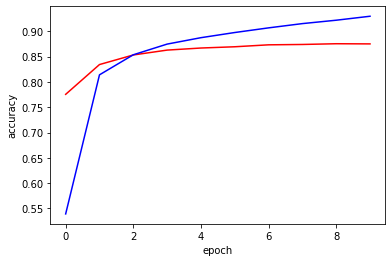

Training complete in 37m 48s
Best Validation Accuracy: 0.8754319654427646, Epoch: 9


In [9]:
#Train
train_model("imagenetOS_base", model, dataloaders['base'], dataset_sizes['base'], criterion, optimizer, num_epochs=10)

## Train from scratch

In [40]:
#Load Resnet50
model = models.resnet50(False)
#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(2048, 201)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model, device_ids = [0, 1, 2, 3])
    model.to(f'cuda:{model.device_ids[0]}')

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Let's use 4 GPUs!


In [47]:
#Train
train_model("imagenetOS_rebalance_600", model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=200)

Epoch 1/200
----------
Iteration: 78/78, Loss: 677.381591796875..5.Train Loss: 5.1952 Acc: 0.0147
Val Loss: 5.1019 Acc: 0.0242

Epoch 2/200
----------
Iteration: 78/78, Loss: 620.1595458984375.8.Train Loss: 4.9259 Acc: 0.0347
Val Loss: 4.8267 Acc: 0.0431

Epoch 3/200
----------
Iteration: 78/78, Loss: 578.6659545898438...Train Loss: 4.7050 Acc: 0.0552
Val Loss: 4.6923 Acc: 0.0620

Epoch 4/200
----------
Iteration: 78/78, Loss: 601.1438598632812...Train Loss: 4.5328 Acc: 0.0750
Val Loss: 4.4730 Acc: 0.0873

Epoch 5/200
----------
Iteration: 78/78, Loss: 564.4683227539062.2.Train Loss: 4.3585 Acc: 0.0954
Val Loss: 4.3357 Acc: 0.1060

Epoch 6/200
----------
Iteration: 78/78, Loss: 509.9085693359375....Train Loss: 4.1764 Acc: 0.1194
Val Loss: 4.1234 Acc: 0.1290

Epoch 7/200
----------
Iteration: 78/78, Loss: 546.3461303710938....Train Loss: 4.0057 Acc: 0.1413
Val Loss: 3.9743 Acc: 0.1398

Epoch 8/200
----------
Iteration: 78/78, Loss: 455.9278259277344....Train Loss: 3.8473 Acc: 0.1636
Val

## Evaluate Models

In [86]:
#Test Resnet50-224
model_OS = models.resnet50()
#Finetune Final few layers to adjust for tiny imagenet input
model_OS.avgpool = nn.AdaptiveAvgPool2d(1)
model_OS.fc = nn.Linear(2048, 201)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model_OS = nn.DataParallel(model_OS, device_ids = [0, 1, 2, 3])
    model_OS.to(f'cuda:{model_OS.device_ids[0]}')
checkpoint = torch.load('/proj/rcs-ssd/ll3504/models/imagenet_rebalance_test_500_1/model_best.pth.tar')
#print(checkpoint["state_dict"])
model_OS.load_state_dict(checkpoint["state_dict"])
#model_OS = model_OS.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_OS.parameters(), lr=0.001, momentum=0.9)

Let's use 4 GPUs!


In [83]:
stat = test_model(model_OS, dataloaders, dataset_sizes, criterion, optimizer)

KeyError: 'test'

In [84]:
def evaluate_models(model, dataloaders, dataset_sizes, criterion, optimizer):
    cities = ['val', 'New_York', 'California', 'Tibet', 'Beijing', 'New_South_Wales', 'United_Kingdom', 'Quebec', 'worst20classes', 'worst20classes1000']
    stats = []
    for city in cities:
        print('Testing '+ city + '......')
        stat = test_model(model, dataloaders[city], dataset_sizes[city], criterion, optimizer)
        stats.append(stat)
        print('Finish testing!\n')
        
    return stats

In [87]:
stats = evaluate_models(model_OS, dataloaders, dataset_sizes, criterion, optimizer)

Testing val......
Iteration: 78/78, Loss: 114.30453491210938.
Test Loss: 0.9702 Acc: 0.7546

Test complete in 0m 21s
Finish testing!

Testing New_York......
Iteration: 79/79, Loss: 125.77305603027344.
Test Loss: 0.9746 Acc: 0.7510

Test complete in 0m 22s
Finish testing!

Testing California......
Iteration: 79/79, Loss: 131.85317993164062.
Test Loss: 1.0206 Acc: 0.7405

Test complete in 0m 21s
Finish testing!

Testing Tibet......
Iteration: 79/79, Loss: 122.41289520263672.
Test Loss: 0.8586 Acc: 0.7811

Test complete in 0m 21s
Finish testing!

Testing Beijing......
Iteration: 79/79, Loss: 156.6033172607422..
Test Loss: 0.9256 Acc: 0.7653

Test complete in 0m 21s
Finish testing!

Testing New_South_Wales......
Iteration: 79/79, Loss: 150.1923370361328..
Test Loss: 0.9903 Acc: 0.7536

Test complete in 0m 16s
Finish testing!

Testing United_Kingdom......
Iteration: 79/79, Loss: 133.2884979248047..
Test Loss: 0.9693 Acc: 0.7456

Test complete in 0m 17s
Finish testing!

Testing Quebec......


In [87]:
def exchange_key(class_to_idx):
    idx_to_class = {}
    for key in class_to_idx:
        idx_to_class[class_to_idx[key]] = key
    return idx_to_class

In [88]:
import re
fileName = imagebase + 'imagenetc/imagenet_labels.txt'
nameDic = {}
with open(fileName, "r") as f:
    temp = f.readlines()
for i in range(len(temp)):
    splits = re.split(' |\n', temp[i])
    nameDic[splits[2]] = splits[0]

In [89]:
fileName = imagebase + 'imagenetc/imagenet_clsidtolabels.txt'
classDic = {}
with open(fileName, "r") as f:
    temp = f.readlines()
for i in range(len(temp)):
    splits = re.split('  |\n|:|, |\'|"', temp[i])
    if ' ' in splits[2]:
        splits[2] = '_'.join(splits[2].split())
    classDic[splits[0]] = splits[2]

In [90]:
class_to_name = exchange_key(nameDic)

In [91]:
idx_to_class = exchange_key(class_to_idx)

In [92]:
import matplotlib.pyplot as plt
def sort_accuracy(stats, idx_to_class, class_to_name):
    cities = ['val', 'New_York', 'California', 'Tibet', 'Beijing', 'New_South_Wales', 'United_Kingdom', 'Quebec', 'worst20classes', 'worst20classes1000']
    stat0 = sorted(stats[0].items(), key=lambda x: x[1][0]/x[1][1], reverse=False)
    sorted_acc = []
    sorted_labels = []
    for stat in stat0:
        sorted_acc.append(stat[1][0]/stat[1][1])
        sorted_labels.append(stat[0])
    target_path = imagebase + 'worst20classes.txt'
    with open(target_path,'w') as f:
        for i in range(20):
            string = str(sorted_labels[i]) + ' ' + idx_to_class[sorted_labels[i]] + ' ' + class_to_name[idx_to_class[sorted_labels[i]]] + '\n'
            f.write(string)
            print(string)
    plt.bar(range(len(sorted_acc)), sorted_acc, width=1)
    plt.ylabel("Accuracy")
    plt.title("Sorted accuracy of 201 classes")
    plt.show()
    for i in range(0, len(cities)):
        frequency = []
        for label in sorted_labels:
            if label in stats[i]:
                frequency.append(stats[i][label][1]/102.01)
            else:
                frequency.append(0)
        plt.bar(range(len(frequency)), frequency, width=1)
        plt.xlabel("201 classes in sorted order (left->right: low->high)")
        plt.ylabel("Frequency (%)")
        plt.title("Frequency of each class in {}".format(cities[i]))
        plt.show()

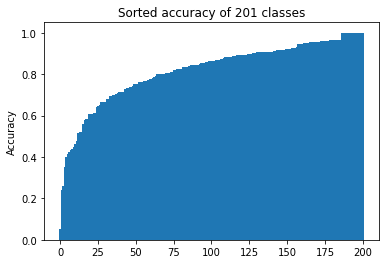

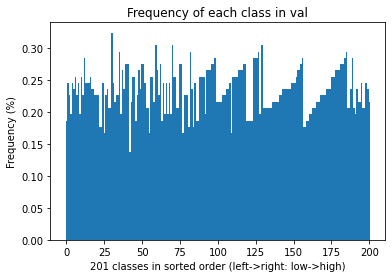

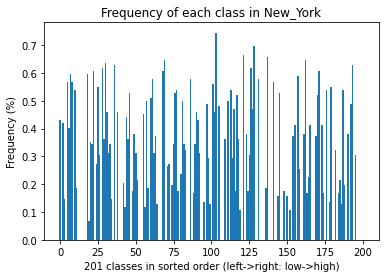

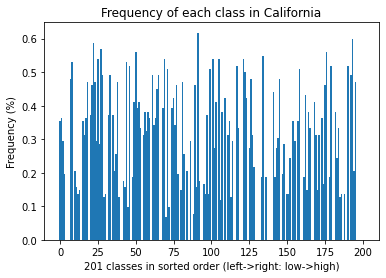

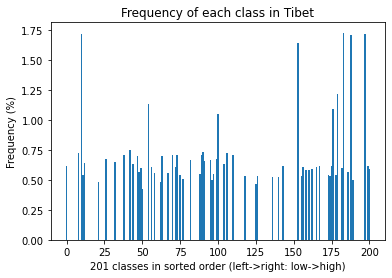

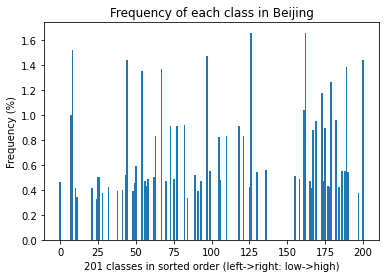

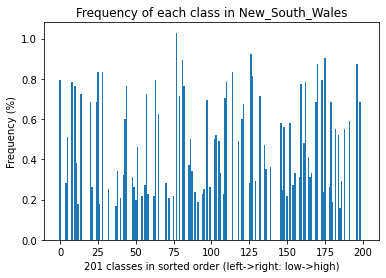

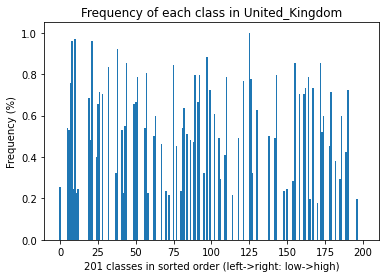

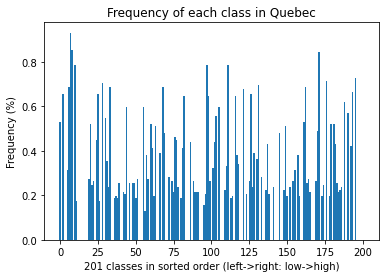

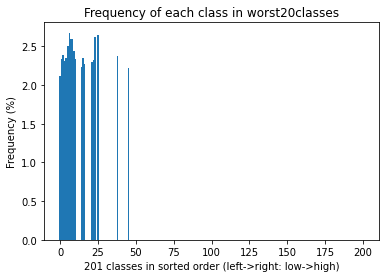

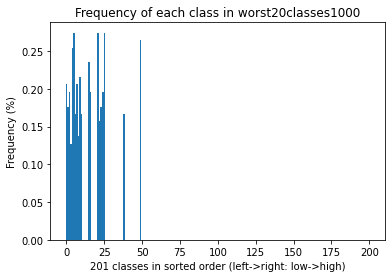

In [93]:
sort_accuracy(stats, idx_to_class, class_to_name)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

def plot_result(fileName):
    with open(fileName, "r") as f:
        temp = f.readlines()
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    epoch = []
    count = 0
    for i in range(0, len(temp)):
        if (i-2)%5 == 0:
            train_losses.append(float(temp[i].split()[-3]))
            train_accs.append(float(temp[i].split()[-1]))
            count += 1
            epoch.append(count)
        if (i-3)%5 == 0:
            valid_losses.append(float(temp[i].split()[-3]))
            valid_accs.append(float(temp[i].split()[-1]))
    plt.plot(epoch,train_losses, color = 'r', linestyle="-", label='tain loss')
    plt.plot(epoch,valid_losses, color = 'b', linestyle="-", label='valid loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    plt.plot(epoch,train_accs, color = 'r', linestyle="-", label='tain accuracy')
    plt.plot(epoch,valid_accs, color = 'b', linestyle="-", label='valid accuracy')
    plt.legend(loc='upper left')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    return 0

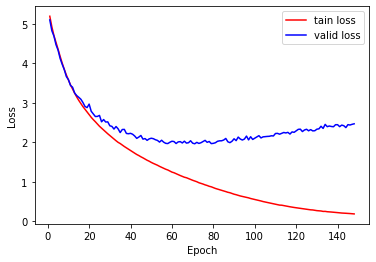

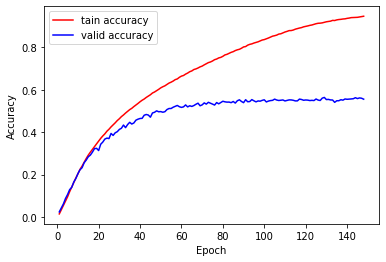

0

In [6]:
plot_result('/proj/rcs-ssd/ll3504/datasets/training_data_600.txt')